# Monte Carlo introduction to Python, NumPy and Jupyter notebooks

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

np.random.seed(1234)
mkl.set_num_threads(2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Estimating π with Monte Carlo

Implement ```sample_points``` function. This function should sample ```count``` points from a $d$-dimensional cube  $[-1, 1]^d$ and return tuple with two NumPy arrays:
- the first tuple element should be an array of points that fall inside the $d$ dimensional ball centered at origin and with unit radius,
- the second element should be an array with points that fall outside that ball.

Point coordinates should be stored row-wise.

In [20]:
def sample_points(count, d):
    points = np.random.uniform(low =- 1, high = 1, size=(count, d))
    radii = np.linalg.norm(points, axis=1)
    inner = points[radii < 1]
    outer = points[radii >= 1]
    
    return inner, outer

### Explanation:

<ul>
    <li> <b>np.random.uniform(low=-1, high=1, size=(count, d)) -</b> generates a count by d NumPy array, where each element is randomly chosen from a uniform distribution between -1 and 1. This represents count points sampled from the d-dimensional cube [-1,1]^d. </li>
    <li> <b>np.linalg.norm(points, axis=1) -</b> calculates the Euclidean norm (distance from the origin) of each point in the points array. This creates a 1D array of length count representing the distance of each point from the origin.</li>
    <li> <b>points[radii < 1] -</b> selects the rows from points where the corresponding element in radii is less than 1. This creates an array of points that fall inside the d-dimensional ball centered at the origin with unit radius. </li>
    <li> <b>points[radii >= 1]</b> selects the rows from points where the corresponding element in radii is more or equal to 1. </li>
</ul>

Implement ```approx_pi_mc``` function, which uses a draw from ```sample_points``` to estimate the vaue of $\pi$. Arguments are:
- ```sample``` - a tuple returned by ```sample_pints``` with d=2. 

Note that you can estimate $\pi$ by approximating the surface area of a $2$-dimensional ball (disc) with a given radius. This is nothing else than approximating the integral of an indicator function over the surface of that ball. Plain Monte Carlo is good at approximating integrals when dimensionality is not overly large.

In [21]:
def approx_pi_mc(sample):
    inner, outer = sample
    n_inner = inner.shape[0]
    n_total = n_inner + outer.shape[0]
    surface_area_ratio = n_inner / n_total
    pi_approx = 4 * surface_area_ratio
    
    return pi_approx

### Explanation:

The function computes the ratio of the number of points in the inner array to the total number of points and multiplies the ratio by 4 to get the approximate value of pi. I multiply the ratio of the number of points inside the circle to the total number of points by 4 because we are only considering a quarter of a circle with radius 1 in our approximation. To get the value of the number pi that corresponds to the entire circle with radius 1, we need to multiply the obtained ratio by 4.


### Visualization

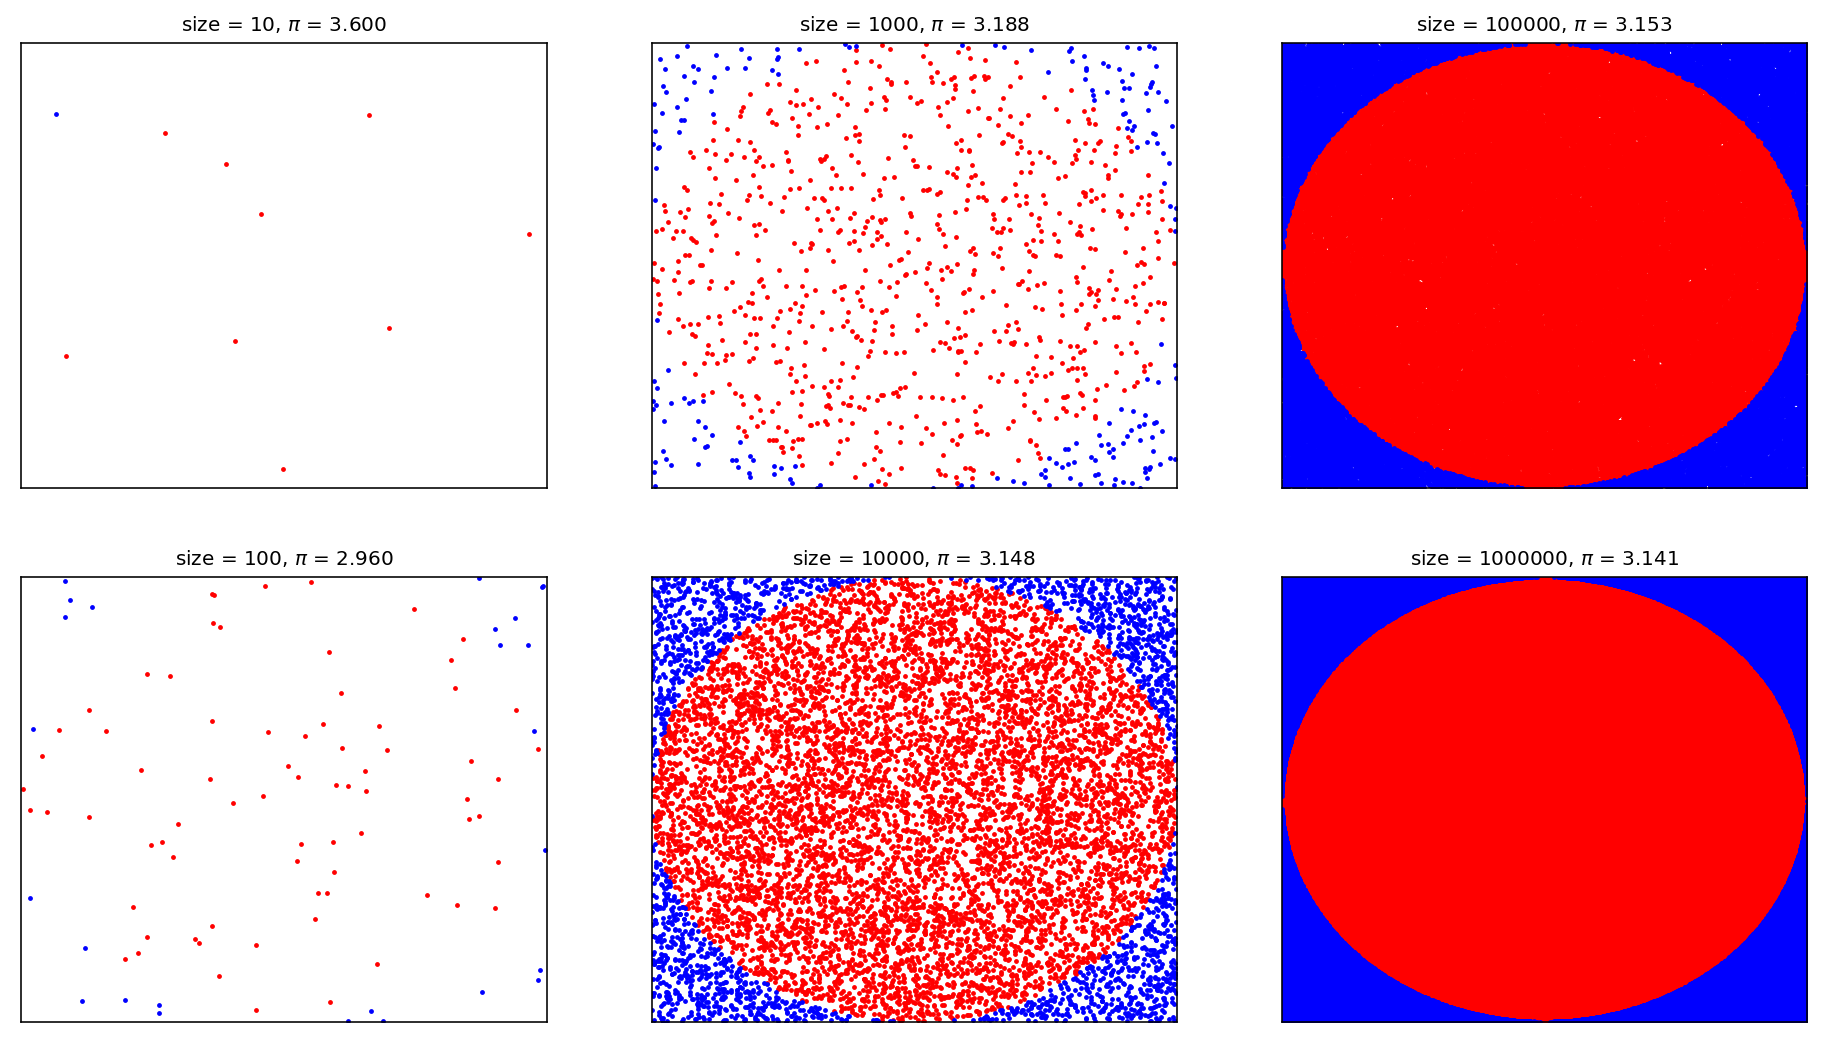

In [22]:
counts = [10 ** i for i in range(1, 7)]

figure, axis = plt.subplots(2, 3, figsize=(16, 9))

def update(idx):
    row, col = idx % 2, idx //2
    n = counts[idx]
    sample = sample_points(n, 2)
    inner, outer = sample

    pi = approx_pi_mc(sample)

    axis[row][col].set_title(f'size = {n}, $\pi$ = {pi:.3f}', fontsize = 10)
    axis[row][col].scatter(inner[:, 0], inner[:, 1], c='r', s=2)
    axis[row][col].scatter(outer[:, 0], outer[:, 1], c='b', s=2)
    axis[row][col].set_xlim((-1, 1))
    axis[row][col].set_ylim((-1, 1))
    axis[row][col].set_xticks([])
    axis[row][col].set_yticks([])

for i in range(len(counts)):
    update(i)

plt.show()

## Monte Carlo cont. - what is the ratio between volume of a $d$-dimensional (inscribed) ball and volume of a $d$-dimensional hypercube?

Use ```sample_pints``` to estimate the ratio between volume of a $d$-dimensional ball and volume of a $d$-dimensional inscribing hypercube. Use ```ratio_sample_size``` points to estimate that ratio.

In [23]:
ratio_sample_size = 10000

def volume_ratio(d):
    in_ball, out_ball = sample_points(ratio_sample_size, d)
    return in_ball.shape[0] / (in_ball.shape[0] + out_ball.shape[0])

### Explanation:

Function is counting the number of points that fall inside the inscribed ball and dividing it by the total number of points sampled.

Lets see how that ratio changes with the number of dimensions.

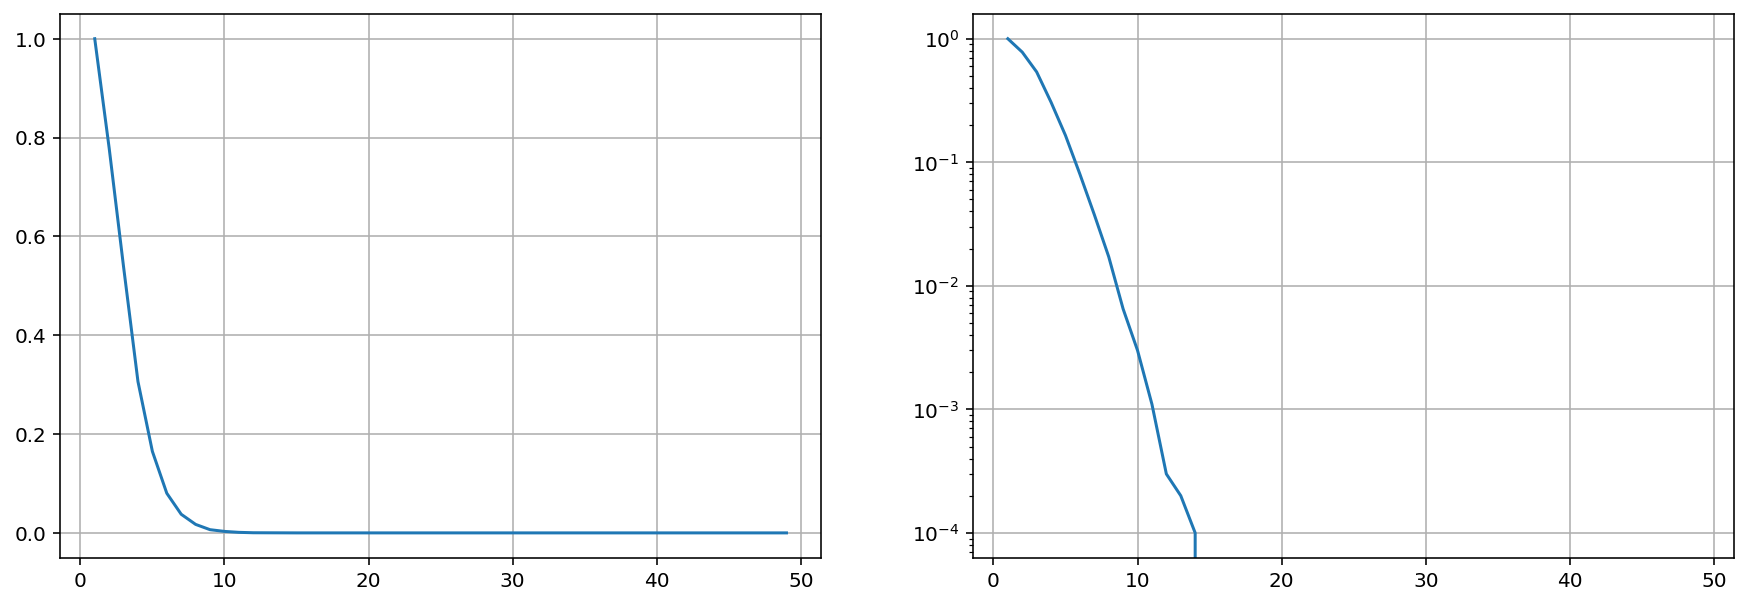

In [24]:
dims = np.arange(1, 50, 1)
ratios = np.vectorize(volume_ratio)(dims)

figure, axis = plt.subplots(1, 2, figsize=(15, 5))
axis[0].grid()
axis[0].plot(dims, ratios)
axis[1].grid()
axis[1].semilogy()
axis[1].plot(dims, ratios);

## Monte Carlo cont. <br> Samplig points uniformly from a $d$-dimensional ball is trivial, right? Not.

Rejection sampling won't work above approx. 10 dimensions - most samples will fall outside the ball and be rejected. But wait! How about we:
- first sample the radius (uniformly),
- then sample the direction (i.e. a unit vector from $\mathbb{R}^d$),
- then generate the point by combining radius and direction?.

Implement ```sample_directions``` function, which returns points sampled randomly from the surface of a $d$-dimensional ball centered at origin and with unit radius. ```sample_directions``` should return an NumPy array, where each row is a sampled point (coordinates).

In [47]:
def sample_directions(count, d):
    points = 2 * np.random.rand(count, d) - 1
    radii = np.linalg.norm(points, axis=1, keepdims=True)
    directions = points / radii
    return directions

### Explanation:

<ol>
    <li>The function takes two arguments: count, which is the number of points to be generated, and d, which is the number of dimensions.</li>
    <li>It generates a matrix of random points in d-dimensional space, where each point is a row in the matrix. The values of the points are uniformly distributed between -1 and 1. </li>
    <li>It computes the radius of each point. This gives the distance of each point from the origin of the sphere.</li>
    <li>It normalizes the points by dividing each point by its radius. This scales each point so that it lies on the surface of a d-dimensional sphere.</li>
</ol>

Lets generate some points.

In [48]:
sample_size = 5000

# First we sample directions:
w = sample_directions(sample_size, 2)

# Then we sample radii:
r = np.random.uniform(low = 0.0, high = 1.0, size = sample_size)

# And now we can generate points:
ball_samples = w * r.reshape((-1, 1))

And plot the distribution.

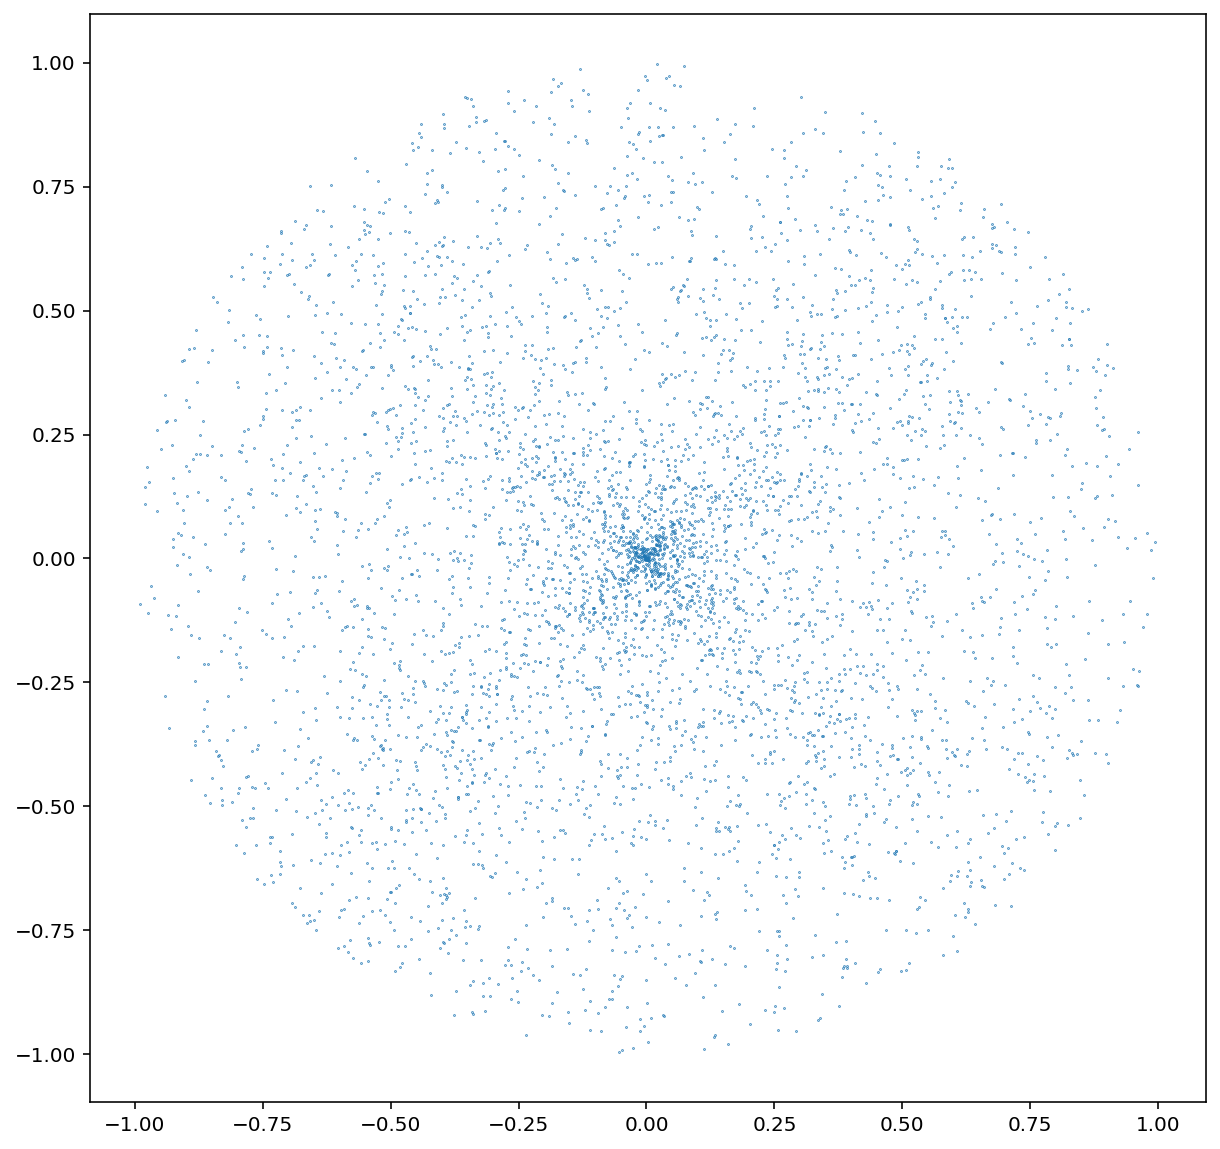

In [49]:
plt.subplots(figsize=(10, 10))
plt.scatter(ball_samples[:, 0], ball_samples[:, 1], s=0.1)
plt.plot();

**Is this a uniform distribution?**

Sampling in many dimensions is not always easy - in fact it's often very hard. Latter in the course we will talk about Markov Chain Monte Carlo (MCMC) methods, which are better at sampling from complicated high-dimensional distributions.

## An exercise - make the coin fair.

Lets say we have an unfair coin, which falls heads 90% of times and tails 10% of times.

In [50]:
def unfair_coin():
    return np.random.choice([0, 1], p=[0.1, 0.9])

Your task is to implement ```make_coin_fair``` function which returns unbiased and uncorrelated samples from $\{0, 1\}$, each with probability $0.5$.

**Note:** the only source of randomness you are allowed to use is ```unfair_coin``` function. Whatever you implement, you should be abl to justify that the returned samples are fair and uncorrelated. 

In [51]:
class Coins:
    def __init__(self):
        self.coin1 = unfair_coin()
        self.coin2 = unfair_coin()
    
    def flip(self):
        self.coin1 = unfair_coin()
        self.coin2 = unfair_coin()
        

def make_coin_fair():
    coins = Coins()
    
    while True:
        if coins.coin1 == coins.coin2: 
            break
        else:
            coins.flip()
        
    return coins.coin1

### Explanation:

Solution: 

We roll twice and only if two different results come up, then we take the first one

There are four possible outcomes: HH, HT, TH, and TT, where H represents heads and T represents tails. The probability of each outcome is:

P(HH) = 0.9 * 0.9 = 0.81

P(HT) = 0.9 * 0.1 = 0.09

P(TH) = 0.1 * 0.9 = 0.09

P(TT) = 0.1 * 0.1 = 0.01

As we can see, the probabilities of getting HT and TH are the same, and each is 0.09. So it is equally likely to pick H or T.

### Let's see what you did there

In [39]:
test_size = 5000

samples = np.array([make_coin_fair() for i in range(test_size)])
heads = np.sum(samples == 1) / samples.shape[0]
tails = np.sum(samples == 0) / samples.shape[0]

acorr = np.correlate(samples, samples, mode='valid')[0] / test_size

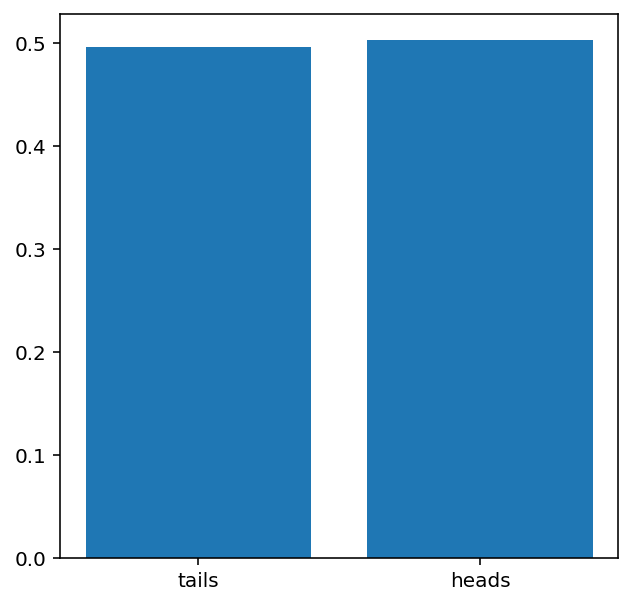

In [40]:
figure, axis = plt.subplots(figsize=(5, 5))
axis.bar([0, 1], [tails, heads])
axis.set_xticks([0, 1])
axis.set_xticklabels(['tails', 'heads'])

display(HTML(f'<h4>(Convolutional) Auto correlation: {acorr}</h4>'))